## 🔧 Environment Setup for Recommender System

This block installs and configures required libraries for building a collaborative filtering model using the `surprise` library.

- Downgrades NumPy to fix compatibility issues with `scikit-surprise`
- Installs/updates pip and setuptools
- Installs `scikit-surprise`
- Imports essential libraries for modeling and visualization


In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install --upgrade pip setuptools

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
E

In [ ]:
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505222 sha256=41dae66001433a5ad40315863a7543a65234931446b6e2c86b0ea8c90992612f
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVD,SVDpp,NMF
from surprise.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 🎬 Load and Explore Ratings & Movies Data

This block reads the user ratings and movie metadata, performs basic analysis, and helps define parameters for recommendation modeling.

- Loads the `ratings.csv` and `movies.csv` files
- Displays a sample of the ratings data
- Checks how many unique movies have been rated
- Shows the distribution of ratings
- Identifies the minimum and maximum rating values (needed for `surprise.Reader`)
- Confirms how many total movies exist, and notes how many were never rated


In [ ]:
#read ratings data, put correct path for rating csv data
data_rating=pd.read_csv(r'data\ml-latest-small\ratings.csv')
data_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# get unique movies_ids
len(data_rating['movieId'].unique())

9724

<Axes: >

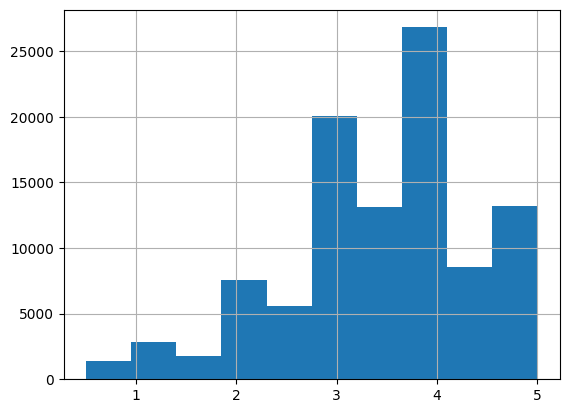

In [ ]:
# show scale of ratings
data_rating['rating'].hist()

In [ ]:
# get minumum rating and maxmuim rating to identify rating_scale in Reader
print('minumum rating: ',data_rating['rating'].min())
print('maximum rating: ',data_rating['rating'].max())

minumum rating:  0.5
maximum rating:  5.0


In [ ]:
# read movie data for prediction, put correct path for read movie data
data_movie=pd.read_csv(r'data\ml-latest-small\movies.csv')

In [ ]:
# give all movies we notice , there 18 movie no users rating them
len(data_movie['movieId'])

9742

## 📊 Matrix Factorization Models for Recommendation

This block sets up and evaluates **three matrix factorization algorithms** using the `surprise` library:

### 🔍 Models:
- **SVD** (Singular Value Decomposition) with GridSearchCV for tuning
- **SVD++**: A variation of SVD that considers implicit feedback
- **NMF** (Non-negative Matrix Factorization) with GridSearchCV

### ⚙️ Steps:
1. Define `Reader` using the rating scale
2. Load data into the `surprise` Dataset format
3. Split into training and testing sets
4. Train, tune, and evaluate the models using RMSE


In [ ]:
reader=Reader(rating_scale=(0.5,5))
data=Dataset.load_from_df(data_rating[['userId','movieId','rating']],reader)

In [ ]:
# use grid search for choose the best hyper parameters
param_grid = {
    'n_factors': [50, 100,150,200],
    'n_epochs': [20, 30,200],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

In [ ]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

In [ ]:
print("Best RMSE for svd:", gs.best_score['rmse'])
print("Best Parameters for svd:", gs.best_params['rmse'])

Best RMSE for svd: 0.8568254340779492
Best Parameters for svd: {'n_factors': 200, 'n_epochs': 200, 'lr_all': 0.005, 'reg_all': 0.1}


In [ ]:
train_set,test_set=train_test_split(data,test_size=0.2,random_state=42)

In [ ]:
model_svd=gs.best_estimator['rmse']
model_svd.fit(train_set)

In [ ]:
predictions=model_svd.test(test_set)
accuracy.rmse(predictions)

RMSE: 0.8538


0.8537522163798503

In [ ]:
# get error from actual_rating and predicted rating to know higher error in this model
pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
                       columns=['userId', 'movieId', 'actual', 'predicted'])
pred_df["error"] = pred_df["actual"] - pred_df["predicted"]


In [ ]:
pred_df.sort_values(by="error", ascending=False).head()

,userId,movieId,actual,predicted,error
5707,89,6686,5.0,1.742895,3.257105
17646,255,420,5.0,1.778124,3.221876
10554,255,344,5.0,1.788259,3.211741
16998,3,2851,5.0,1.956074,3.043926
10744,89,8372,5.0,1.956346,3.043654


In [ ]:
model_svdpp=SVDpp()

In [ ]:
model_svdpp.fit(train_set)

In [ ]:
predictions2=model_svdpp.test(test_set)
accuracy.rmse(predictions2)

RMSE: 0.8669


0.8668667318109596

In [ ]:
param_grid_for_nmf = {
    'n_factors': [15, 30, 50],
    'n_epochs': [50, 100],
    'reg_pu': [0.06, 0.1],
    'reg_qi': [0.06, 0.1]
}

In [ ]:
gs3=GridSearchCV(NMF, param_grid_for_nmf, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs3.fit(data)

In [ ]:
print("Best RMSE for nmf:", gs3.best_score['rmse'])
print("Best Parameters for nmf:", gs3.best_params['rmse'])

Best RMSE for nmf: 0.8990204358865553
Best Parameters for nmf: {'n_factors': 50, 'n_epochs': 50, 'reg_pu': 0.1, 'reg_qi': 0.1}


In [ ]:
model_nmf=gs3.best_estimator['rmse']

In [ ]:
model_nmf.fit(train_set)

In [ ]:
predictions3=model_nmf.test(test_set)
accuracy.rmse(predictions3)

RMSE: 0.9024


0.902369688595469

## 📊 User-Item Matrix for Predictions & Model Saving/Loading

This block performs the following tasks:

1. **Creates a User-Item Matrix** from the ratings data and movie metadata.
   - Each row represents a user.
   - Each column represents a movie title.
   - The values in the matrix follow these rules:
     - If the user has **already rated** the movie → **0** is placed (to avoid re-recommending).
     - If the movie has **never been rated by any user** (cold-start movie) → **0** is placed.
       - This avoids unreliable predictions, since matrix factorization (e.g., SVD) has no real data to learn from for such movies.
     - If the movie is **unrated by the current user but has been rated by others** → the model predicts a **personalized score**.
   - This results in a user-item matrix containing realistic and meaningful recommendation scores only where prediction is supported by prior user data.

2. **Saves the trained SVD model** (best-performing) to disk for reuse.

3. **Loads the SVD model** from disk without retraining, allowing for consistent predictions.

4. **Exports the prediction matrix** to a CSV file for later analysis, visualization, or top-N recommendation generation.


In [ ]:
def top_n_movie_for_user(model, rating_df, movie_df):
    """
    Generates a user-item matrix DataFrame where each row is a user, each column is a movie title,
    and values are predicted ratings for unrated movies (only if the movie has at least one rating),
    and 0 otherwise (already rated or completely unrated).

    Parameters:
    -----------
    model : surprise.AlgoBase or similar
        A trained recommendation model with a `predict(user_id, item_id)` method.

    rating_df : pandas.DataFrame
        DataFrame containing user ratings with columns ['userId', 'movieId'].

    movie_df : pandas.DataFrame
        DataFrame containing movie metadata with columns ['movieId', 'title'].

    Returns:
    --------
    df_matrix : pandas.DataFrame
        A DataFrame with userId as index, movie titles as columns, and values as predicted ratings
        or 0 if the user or no user has rated that movie.
    """
    rating_df = rating_df.copy()
    movie_df = movie_df.copy()

    user_ids = rating_df['userId'].unique()
    movie_title = dict(zip(movie_df['movieId'], movie_df['title']))
    movie_ids = list(movie_title.keys())
    movie_titles = list(movie_title.values())

    globally_rated_movies = set(rating_df['movieId'].unique())

    data = []
    for user_id in user_ids:
        user_rated = set(rating_df[rating_df['userId'] == user_id]['movieId'])
        user_row = []

        for movie_id in movie_ids:
            if movie_id in user_rated or movie_id not in globally_rated_movies:
                user_row.append(0)
            else:
                pred = model.predict(user_id, movie_id).est
                user_row.append(round(pred, 2))

        data.append(user_row)

    df_matrix = pd.DataFrame(data, index=user_ids, columns=movie_titles)
    return df_matrix

In [ ]:
# the best model is SVD so we use it in prediction
# put correct path for save svd model
with open(r"models\svd_model.pkl", "wb") as f:
    pickle.dump(model_svd, f)

In [ ]:
# Load model, put correct path for load model
with open(r"models\svd_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
matrix_movies=top_n_movie_for_user(loaded_model,data_rating,data_movie)
matrix_movies

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
1,0.00,4.01,0.00,3.49,3.77,0.00,3.82,3.84,3.64,4.09,...,4.01,4.06,4.32,4.44,4.10,4.19,4.19,4.19,4.26,4.46
2,3.88,3.47,3.45,3.01,3.21,3.82,3.12,3.27,3.15,3.62,...,3.34,3.42,3.69,3.54,3.38,3.57,3.57,3.57,3.39,3.50
3,2.44,2.31,1.85,1.78,2.01,2.54,1.80,2.12,1.93,2.75,...,1.95,2.19,2.47,2.14,2.54,2.30,2.30,2.30,2.44,2.22
4,3.83,3.36,2.96,2.82,2.63,3.66,3.14,3.18,2.89,3.22,...,3.18,3.44,3.70,3.38,3.68,3.42,3.42,3.42,3.68,3.62
5,0.00,3.28,3.22,2.60,2.79,3.55,2.99,3.07,2.65,3.21,...,3.33,3.33,3.47,3.57,3.35,3.39,3.39,3.39,3.42,3.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.00,3.47,3.38,2.81,2.93,3.99,0.00,3.17,2.93,3.38,...,3.62,3.29,3.58,3.74,3.46,3.54,3.54,3.54,3.50,3.89
607,0.00,3.76,4.02,3.22,3.35,4.18,3.23,3.20,3.34,3.77,...,3.87,3.54,3.90,3.63,3.97,3.77,3.77,3.77,3.60,3.96
608,0.00,0.00,0.00,2.57,2.49,3.84,2.64,2.81,2.74,0.00,...,3.54,3.25,3.53,3.40,3.16,3.34,3.34,3.34,3.21,3.27
609,0.00,3.22,3.08,2.57,2.82,3.67,3.00,2.96,2.75,0.00,...,3.27,3.08,3.52,3.56,3.23,3.34,3.34,3.34,3.34,3.53


In [ ]:
# save movies predictions for each user in csv file
matrix_movies.to_csv("user_movie_prediction_from_SVD_model.csv",index=True)